In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns
from clust import KMeans
from clust import elbow

[0. 0. 0. 1. 1. 1. 1. 2. 2. 2.]


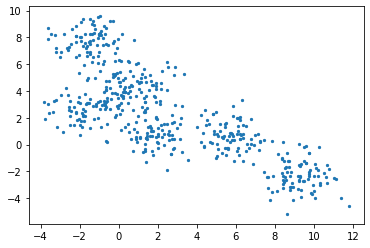

In [6]:
X, y = make_blobs(n_samples=500, n_features=2, centers=6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=5)

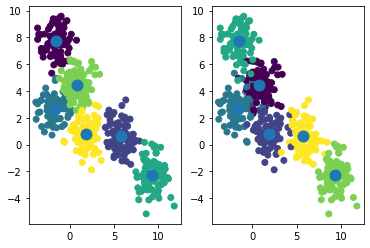

In [9]:
m = KMeans(X, n_clusters=6, n_features=2).fit()

# fig, ax = plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.scatter(m.X[:, 0], m.X[:, 1], c=m.labels)
plt.scatter(m.centroids[:, 0], m.centroids[:, 1], s=120)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(m.centroids[:, 0], m.centroids[:, 1], s=120)


In [10]:
solve = elbow(X, n_features=2, kmax=8)

6

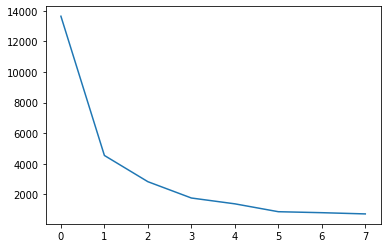

In [11]:
plt.plot(solve.variances_for_k)
solve.choose_k()